## <font color=darkblue> Second order gradient descent for Optimization and Machine Learning </font>


In this notebook, we provide an **overview of second order gradient-based optimization algorithms** which completes the first session **on first order methods and accelerated algorithms**. Supervised learning applications are usually based on the minimization of an objective function on $\mathbb{R}^d$ (kernel based SVM models, penalized regression, maximum likelihood estimation of neural networks) and accelerated gradient methods are the go-to solutions to solve these optimization problems.

The results provided in this notebook are valid with assumptions on the target functions such as convexity or strong convexity (some of them may be relaxed). Although these algorithms are widely used, keep in mind that these assumptions do not hold in practice and that  non-convexity stems from the arbitrary form of the loss functions used in machine learning.

This will motivate **additional sessions on alternative methods such as evolutionary approaches for difficult non-linear non-convex optimisation problems** in continuous and discrete domains (for instance the CMA-ES algorithm).

### <font color=darkred> Bibliography & additional ressources </font>

- [1] Convex Optimization, S. Boyd & L. Vandenberghe, 2009, https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf
``Very complete book on convex optimization and gradient descent algorithms (full gradient, Newton's method, constrained problems)``
, etc.
- [2] Convex Optimization: Algorithms and
Complexity, S. Bubeck, 2015, https://arxiv.org/pdf/1405.4980.pdf

-  [3] Probabilistic machine learning: an introduction, Kevin P. Murphy, 2022, https://probml.github.io/pml-book/book1.html
``Full book online with all basics on machine learning. Not state-of-the-art but very good introduction``

- [4] Learning theory from first principles, F. Bach, 2023, https://www.di.ens.fr/~fbach/ltfp_book.pdf
``Much more advanced reference, Chapter 5 on optimization``

- [5] Algorithms for optimization, M. J. Kochenderfer and T. A. Wheeler, 2019.


### <font color=darkred>Introduction : general framework & motivations</font>

Parameter inference in machine learning often boils down to solving

\begin{equation*}
\mathrm{argmin}_{\theta \in \mathbb{R}^d} \,\left\{\ell_n(\theta)=\frac 1n \sum_{i=1}^n \ell(\theta, y_i, x_i) + \lambda \mathrm{pen}(\theta)\right\}\,,
\end{equation*}

with $\lambda>0$, $\mathrm{pen}(\cdot)$ some penalization function and $(x_i,y_i)_{1\leq i\leq n}$ are ``training examples of inputs and outputs`` (in a supervised setting), and $\theta$ is an ``unknown parameter to be estimated.``


**Examples of penalization functions**:

- $\mathrm{pen}(\theta) =  \|\theta\|_2^2$ (Ridge for regularization).

- $\mathrm{pen}(\theta) = \|\theta\|_1$ (Lasso for sparsity),
see Tibshirani, R. (1996). 
``Regression shrinkage and selection via the lasso. Journal of the Royal Statistical Society: Series B (Methodological), 58(1), 267–288, and all extensions``


**First order necessary condition**
		
Let $f : \mathbb{R} \to \mathbb{R}$ be a differentiable function. If $x^{\star}$ is a local extremum (minimum/maximum) then $f'(x^{\star}) = 0$.
		
Illustration from [4]. For **convex functions, we only need to look for stationary points**. This is
not the case for potentially non-convex functions. For example, in one dimension below, all
red points are stationary points that are not the global minimum (which is in green).



![](https://drive.google.com/uc?export=view&id=1dB0TjQVALJeEVglIXDV-Bz6ZdLYT1avD)
	
**Generalization for $d>1$**
		
Let $f: \mathbb{R}^d \to \mathbb{R}$ be a differentiable function. If $x^{\star}$ is a local extremum then $\nabla f(x^{\star}) = 0$. Points such that $\nabla f(x^{\star}) = 0$ are called critical points. Critical points are not always extrema (consider $x \mapsto x^3$).


*Some useful gradients*

- If $f: \mathbb{R} \to \mathbb{R}$, $\nabla f(x) = f'(x)$.

- $f:x \mapsto \langle a,x\rangle$: $\nabla f(x) = a$.
	
- $f:x \mapsto x^T A x$: $\nabla f(x) = (A + A^T) x$.
	
- Particular case: $f: x \mapsto \|x\|^2$, $\nabla f(x) = 2x$.


In [1]:
import numpy as np
import scipy
import pandas as pd
import autograd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=2)
plt.rcParams.update(
    {
        "font.size": 25,
        "figure.figsize": (14, 7),
        "axes.grid": True,
        "grid.color": "#93a1a1",
        "grid.alpha": 0.3,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

#### Simple cost function to test the algorithms

We may consider the Booth and Rozenbrock functions, see fo instance [5], to test the optimization procedures presented in this session:
$$
f_{\mathrm{booth}} : (x_1,x_2) \mapsto (x_1+2x_2-7)^2 + (2x_1+x_2-5)^2
$$
and
$$
f_{\mathrm{roz}} : (x_1,x_2) \mapsto (1-x_1)^2 + 100(x_2-x_1^2)^2\,.
$$


In [2]:
def rozenbrock(x):
    return (1-x[0])**2 + 100*(x[1] - x[0]**2)**2

In [3]:
def booth(x, y):
    return (x + 2*y - 7)**2 + (2*x + y - 5)**2

In [5]:
import matplotlib.cm as cm

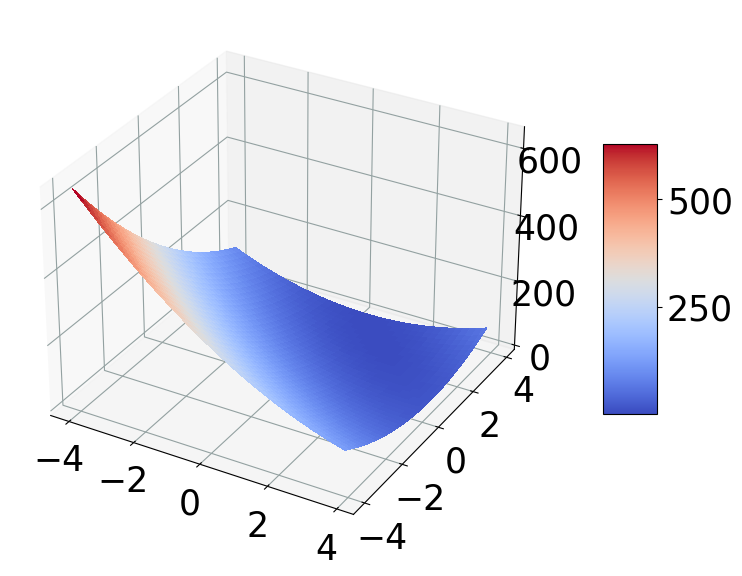

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x = np.arange(-4, 4, 0.1)
y = np.arange(-4, 4, 0.1)
x, y = np.meshgrid(x, y)
z = booth(x,y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### <font color=darkred> Newton's method </font>

In this setting, we consider the second order Taylor expansion of the target $\ell_n$. More precisely, this approach proposes to locally **approximate the function $\ell_n$ around $\theta_k$ by a second-order Taylor expansion**.

Illustration from https://francisbach.com/self-concordant-analysis-newton/
![](https://drive.google.com/uc?export=view&id=1aQz3wROslBIqRB9ih_zr3LEES6LWPS0J)


In the case where $\nabla^2 \ell_n(\theta_k)$ is definite positive, the function
$$
\theta\mapsto \ell_n(\theta_k) + \theta^\top\nabla\ell_n(\theta_k) + \frac{1}{2}\theta^\top\nabla^2 \ell_n(\theta_k)\theta
$$
admits a unique minimum at 
$$
\theta_* = -(\nabla^2 \ell_n(\theta_k))^{-1}\nabla\ell_n(\theta_k)\,.
$$
This motivates the following iterative algorithm:
$$
\theta_{k+1} = \theta_k - (\nabla^2 \ell_n(\theta_k))^{-1}\nabla\ell_n(\theta_k)\,.
$$

###### **Implementation from scratch**

In [7]:
import autograd.numpy as np
import autograd

In [8]:
def NR_update(f, x0):
    g = autograd.jacobian(f)
    h = autograd.hessian(f)

    x = x0
    
    gx = np.squeeze(g(x))
    hx = np.squeeze(h(x))
    
    #####
    # A compléter
    delta = np.linalg.multi_dot([np.linalg.inv(hx), gx])
    x = x - delta
    #####
    return x

In [9]:
def NR_loop(f, x0, maxiter=50):
    """
    Inputs
    ----------
    f: function to be optimized
    x0: initial parameter estimate
    maxiter: maximum number of updates
    
    Outputs
    -------
    params: estimators
    loglik: sequence of loglikelihood along iterations
    """
    params = x0
    loglik = f(x0)
    for _ in range(maxiter):
        new_params = NR_update(f, params)
        loglik = np.append(loglik,f(new_params))
        params = new_params
        
    return params,  loglik

- Compute the gradient and the Hessian of the Booth function. 

- Write an iteration of the Newton update for this function

In [ ]:
####
# A compléter
# Ecrire l'optimisation par la méthode de Newton de la fonction de Rozenbrock
####


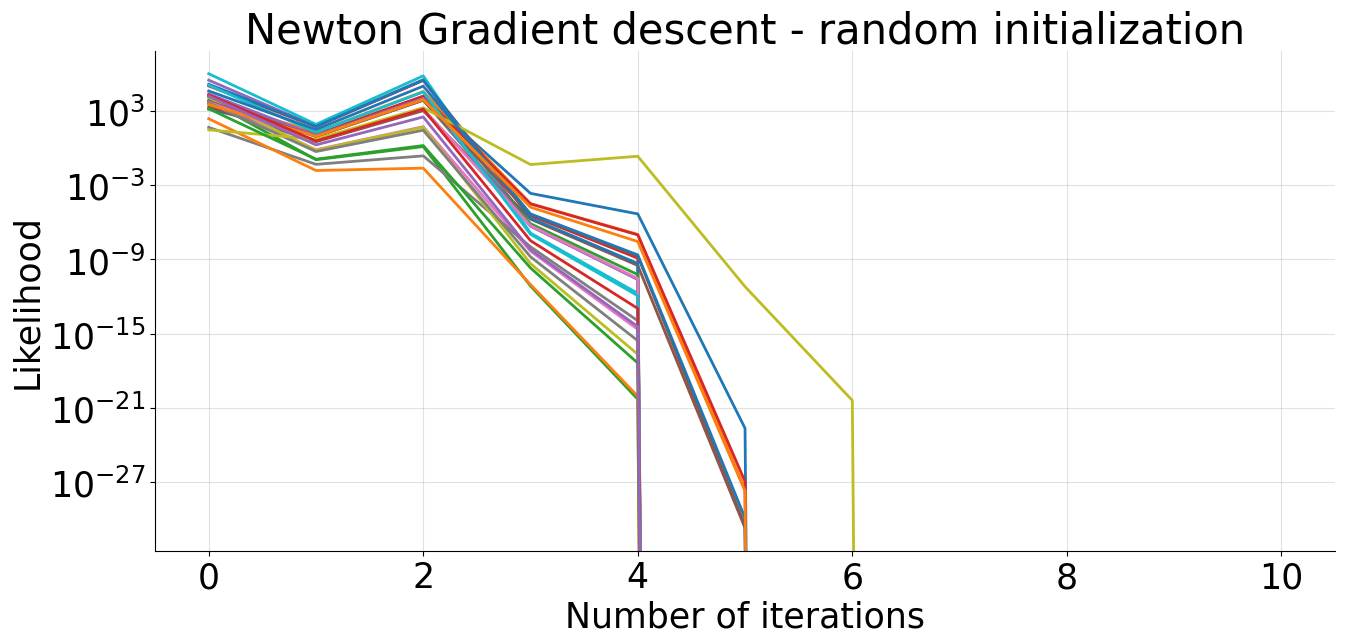

In [10]:
f = rozenbrock
iterations = 10
for exp_it in range(25):
    x0 = 5*np.random.randn(2)
    params,  loglik = NR_loop(f, x0, iterations)
    plt.plot(loglik, '-', lw=2)
# Configure plot
plt.yscale("log")
plt.title('Newton Gradient descent - random initialization')
plt.xlabel('Number of iterations')
plt.ylabel('Likelihood')
plt.tight_layout();

###### **Convergence**

Assum that the target function $f$ is convex and twice differentiable. Assume also that:
- $\nabla f$ is $L$-Lipschitz ;
- $\nabla^2 f$ is $M$-Lipschitz ;
- $f$ is strongly convex with parameter $m$.

Then, there exists a constant $c$, for all $k>0$,
$$
f(x_{k+k_0}) - f(x_*) \leq c \left(\frac{1}{2}\right)^{2^k}\,,
$$
where $k_0$ is the number of steps until $\|\nabla f(x_{k_0+1})\|$ is below a fixed threshold.

Locally, the method is quadratically convergent, that is, there exists $c>0$, such that if $\|x_k –x_*\|\leq c$, then $\|x_{k+1} –x_*\|/c\leq (\|x_k –x_*\|/c)^2$. Thies yields
$$
\|x_k –x_*\|⩽c(\|x_{k_0} –x_*\|/c)^{2^{k-k_0}},
$$
where $k_0$ is such that $\|x_k –x_*\|\leq c$.

Newton's method is **sensitive to initial conditions**, in particular for non-convex objective functions. 

Newton’s method is **very computationally intensive**. The computation of the inverse Hessian scales as **$O(d^3)$** which is prohibitive in high dimensional settings.

###### **Built-in optimization**

In [11]:
!pip install autograd-minimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import torch
from autograd_minimize import minimize
x0 = 5*np.random.randn(2)
minimize(f, x0, backend='torch')

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0
        x: [ 1.000e+00  1.000e+00]
      nit: 81
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 4.975e-01  9.950e-01]
            [ 9.950e-01  1.995e+00]]
     nfev: 102
     njev: 102

In [13]:
minimize(f, x0, method='Newton-CG', precision='float64', tol=1e-8)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.485150501411498e-27
       x: [ 1.000e+00  1.000e+00]
     nit: 37
     jac: [ 2.344e-12 -1.177e-12]
    nfev: 46
    njev: 46
    nhev: 56

### <font color=darkred> Quasi Newton - Broyden-Fletcher-Goldfarb-Shanno (BFGS) method</font>

Computation of the Hessian matrix is sometimes **intractable or computationally very sensitive**. Quasi-Newton approaches propose to use an update similar to the Newton Raphson algorithm with an approximation of the Hessian, i.e.
$$
\theta_{k+1} = \theta_k - \gamma_k A_k^{-1}\nabla\ell_n(\theta_k)\,.
$$

In this framework, $A_k$ aims at approximating $\nabla^2 \ell_n(\theta_k)$. This approximation satisfies in general the quasi-Newton condition:
$$
A_{k+1}(\theta_{k+1} - \theta_k) = \nabla \ell_n(\theta_{k+1}) - \nabla \ell_n(\theta_{k})\,.
$$

In the BFGS setting, the approximation of the Hessian matrix is computed recursively as follows.
- $\delta_k = \theta_{k+1}-\theta_k$.
- $d_k = \nabla\ell_n(\theta_{k+1}) -\nabla\ell_n(\theta_k)$. 
- $A_{k+1} = A_k + \left(d_k^\top \delta_k\right)^{-1}d_kd_k^\top - \left(\delta_k^\top A_k\delta_k\right)^{-1}A_k\delta_k(A_k\delta_k)^\top$. 

Using **Woodbury formula**, we can directly compute $A_{k+1}^{-1}$ as follows.
\begin{align*}
\alpha_k &= (d_k^\top \delta_k)^{-1}\,,\\
A_{k+1}^{-1} &= \left(I - \alpha_k \delta_k d_k^\top\right)A_{k}^{-1}\left(I - \alpha_k d_k\delta_k^\top\right) + \alpha_k \delta_k \delta_k^\top
\end{align*}

###### **Line search**

Computing the step length $\gamma_k$ amounts to solving a tradeoff between decreasing the value of $\ell_n$ and not spending too much time at each iteration.

A popular line search condition targets to choose $\gamma_k$ such that:
$$
\ell_n(\theta_k + \gamma_kp_k ) \leq \ell_n (\theta_k ) + c_1 \gamma_k \nabla \ell_n(\theta_k)^\top p_k\,,
$$
for $p_k = -A_k^{-1}\nabla\ell_n(\theta_k)$ some constant $0<c_1<1$.

A second requirement to avoid too short steps requires that
$$
\nabla \ell_n(\theta_k + \gamma_k p_k )^\top
p_k \geq c_2 \nabla \ell_n(\theta_k)^\top p_k
$$
where $c_1<c_2<1$.

###### **Implementation from scratch**

In [ ]:
def line_search(f,x,p,nabla):
    """
    Inputs
    ----------
    f: function to be optimized
    x: current parameter estimate
    p: current value of p
    nabla: current value of the gradient 
    
    Outputs
    -------
    gamma: step-size 
    """
    g = autograd.jacobian(f)
    
    gamma = 1
    c1 = 1e-4 
    c2 = 0.9 
    
    fx = f(x)
    x_new = x + gamma * p 
    nabla_new = g(x_new)
    ###
    # A compléter
    ####
    while f(x_new) >= fx + (c1*gamma*nabla.T@p) or nabla_new.T@p <= c2*nabla.T@p : 
        gamma *= 0.5
        x_new = x + gamma * p 
        nabla_new = g(x_new)
    return gamma

In [ ]:
def BFGS_loop(f,x0,max_it):
    """
    Inputs
    ----------
    f: function to be optimised 
    x0: starting point
    max_it: maximum number of iterations

    Outputs:
    ---------- 
    params: parameter estimate 
    """
    d = len(x0) 
    g = autograd.jacobian(f)
    nabla = g(x0)

    H = np.eye(d) 
    params = x0[:]
    it = 1
    while it < max_it:
        it += 1
        ###
        # A compléter
        # search direction p and step size with line search
        ###
        p = -H@nabla 
        a = line_search(f,params,p,nabla) 
        s = a * p 
        
        params_new = params + a * p 
        nabla_new = g(params_new)
        
        y = nabla_new - nabla 
        y = np.array([y])
        s = np.array([s])
        y = np.reshape(y,(d,1))
        s = np.reshape(s,(d,1))

        r = 1/(y.T@s)
 
        li = (np.eye(d)-(r*((s@(y.T)))))
        ri = (np.eye(d)-(r*((y@(s.T)))))
        hess_inter = li@H@ri
        H = hess_inter + (r*((s@(s.T)))) 
        
        nabla = nabla_new[:] 
        params = params_new[:]

    return params

Maximum iterations reached!


In [ ]:
params = BFGS_loop(f,x0,5)

array([0.19, 0.02])

###### **Built-in optimization**

In [ ]:
minimize(f, x0, method='BFGS', precision='float64', tol=1e-8)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.763131196012412e-22
        x: [ 1.000e+00  1.000e+00]
      nit: 58
      jac: [ 3.736e-10 -1.958e-10]
 hess_inv: [[ 4.965e-01  9.925e-01]
            [ 9.925e-01  1.989e+00]]
     nfev: 78
     njev: 78

### <font color=darkred> Application to Design</font>

###### **Loss function**

###### **Optimization**